# ACD Model Testing

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from glove import *
from myLayers import CustomAttention, Projection, MaskSum, WordAspectFusion

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras

## Load ACD model

In [3]:
custom_objects = {'MaskSum': MaskSum, 'WordAspectFusion': WordAspectFusion,
                  'CustomAttention': CustomAttention, 'Projection': Projection}
ACD_model = keras.models.load_model('../trained_models/ACD_model.h5', custom_objects=custom_objects)

## Load test dataset and set data types

In [4]:
reviews = pd.read_csv('../data/reviews_revision_test.csv', index_col=0)

reviews['ids'] = reviews['ids'].apply(lambda x: list(map(int, x[1:-1].split(', '))))
reviews['meta_review_pros'] = reviews['meta_review_pros'].apply(lambda x: x[2:-2].split('\', \''))
reviews['meta_review_so-so'] = reviews['meta_review_so-so'].apply(lambda x: x[2:-2].split('\', \''))
reviews['meta_review_cons'] = reviews['meta_review_cons'].apply(lambda x: x[2:-2].split('\', \''))
reviews['meta_review_labels'] = reviews['meta_review_labels'].apply(lambda x: x[2:-2].split('\', \''))

## Load labels

In [5]:
with open('../data/top_labels.txt', 'r', encoding='utf-8') as f:
    f_lines = f.readlines()
    types = []
    aspects = []
    for i in f_lines:
        types.append(i.strip().split('#')[0].replace('_', ' '))
        aspects.append(i.strip().replace('#', ' ').replace('_', ' '))
        
types = np.array(types)

## Pad ids of each entry to match max length

In [6]:
padded_ids = keras.preprocessing.sequence.pad_sequences(
    reviews['ids'].to_numpy(), padding="post", value=0, maxlen=ACD_model.input_shape[-1]
)

sentiment_list = ['Αρνητικό', 'Ουδέτερο', 'Θετικό']

## Aspect encoder

In [7]:
def encode_category(prod_type, label):
    def category_function(df):
        if prod_type == df['meta_product_type'] and label in df['meta_review_labels']:
            return 1
        elif prod_type == 'Γενικά' and label in df['meta_review_labels']:
            return 1
        else:
            return 0
    return category_function

In [8]:
encoded_aspects = {}
for t, a in zip(types, aspects):
    encoded_aspects[a] = reviews.apply(encode_category(t, a.replace(t + ' ', '')), axis='columns').to_numpy()

## Type encoder

In [9]:
onehot = OneHotEncoder(sparse=False)
encoded_type = onehot.fit_transform(np.expand_dims(reviews['meta_product_type'].values, axis=-1))

## Evaluate model for each aspect

In [10]:
type_pred = []
aspects_pred = {}
for a in encoded_aspects.keys():
    aspects_pred[a] = []

for input_ids in padded_ids:

    # Detect aspects
    aspect_prob = np.squeeze(ACD_model.predict(np.expand_dims(input_ids, axis=0)))
    aspect_prob_cutoff = np.where(aspect_prob > 0.5, aspect_prob,
                                  np.zeros(aspect_prob.shape, dtype='float'))

    # Find most likely product type
    unique_types = np.unique(types)
    unique_types = np.delete(unique_types, np.where(unique_types == 'Γενικά'))
    sums = []
    scores = {}
    for group in unique_types:
        sums.append(aspect_prob_cutoff[types == group].sum())

    likely_type = unique_types[np.argmax(np.array(sums))]
    
    # Encode type prediction to one-hot
    type_pred.append(onehot.transform([[likely_type]])[0])
    
    # Encode aspect prediction
    for i in range(aspect_prob.size):
        if aspect_prob[i] > 0.5 and (types[i] == likely_type or types[i] == 'Γενικά'):
            aspects_pred[aspects[i]].append(1)
        else:
            aspects_pred[aspects[i]].append(0)

type_pred = np.array(type_pred)
for a in aspects_pred.keys():
    aspects_pred[a] = np.array(aspects_pred[a])

In [11]:
f1 = []
for aspect, pred in aspects_pred.items():
    f1.append(metrics.f1_score(encoded_aspects[aspect], pred, average='weighted'))
    
f1 = np.array(f1)
aspects = np.array(list(aspects_pred.keys()))
sort_idx = np.argsort(f1)[-1::-1]

In [12]:
for a, f in zip(aspects[sort_idx], f1[sort_idx]):
    print(f'{a} & {f*100:.2f}\\\\')

Κινητά Τηλέφωνα Φωτογραφίες & 96.18\\
Activity Trackers Ακρίβεια μετρήσεων & 95.35\\
PS4 Games Single Player & 94.90\\
PS4 Games Γραφικά & 94.80\\
Gaming Headsets Ποιότητα Μικροφώνου & 93.63\\
Gaming Headsets Ποιότητα κατασκευής & 93.35\\
PS4 Games Gameplay & 93.32\\
Gaming Headsets Ποιότητα ήχου & 91.71\\
Activity Trackers Αυτονομία μπαταρίας & 91.26\\
Activity Trackers Πλήθος λειτουργιών & 90.49\\
Κινητά Τηλέφωνα Ταχύτητα & 90.46\\
Κινητά Τηλέφωνα Μπαταρία & 90.42\\
Κινητά Τηλέφωνα Καταγραφή Video & 89.32\\
PS4 Games Αντοχή στο χρόνο & 88.87\\
Κινητά Τηλέφωνα Οθόνη & 86.91\\
Γενικά Σχέση ποιότητας τιμής & 84.99\\


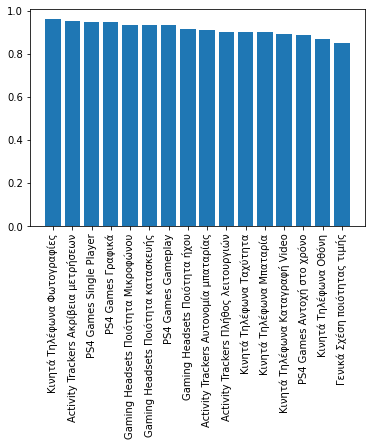

In [13]:
plt.bar(aspects[sort_idx], f1[sort_idx])
plt.xticks(rotation=90)
plt.show()

In [14]:
f1.mean()

0.9162353970003441

In [15]:
f1.std()

0.030486915491103696

In [16]:
for aspect, pred in aspects_pred.items():
    print('------------------------------------------------------------------------')
    print(f'Evaluation for aspect "{aspect}"\n')
    
    print('Confusion matrix\n')
    print(metrics.confusion_matrix(encoded_aspects[aspect], pred))
    print('\n')

    print(metrics.classification_report(encoded_aspects[aspect], pred))
    print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Evaluation for aspect "Γενικά Σχέση ποιότητας τιμής"

Confusion matrix

[[60 12]
 [ 8 53]]


              precision    recall  f1-score   support

           0       0.88      0.83      0.86        72
           1       0.82      0.87      0.84        61

    accuracy                           0.85       133
   macro avg       0.85      0.85      0.85       133
weighted avg       0.85      0.85      0.85       133

------------------------------------------------------------------------
------------------------------------------------------------------------
Evaluation for aspect "Κινητά Τηλέφωνα Φωτογραφίες"

Confusion matrix

[[99  1]
 [ 4 29]]


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       100
           1       0.97      0.88      0.92        33

    accuracy                           0.96       133
   macro avg       0.96      0.93      0.95       1

In [17]:
onehot.get_feature_names_out()

array(['x0_Activity Trackers', 'x0_Gaming Headsets', 'x0_PS4 Games',
       'x0_Κινητά Τηλέφωνα'], dtype=object)

In [18]:
encoded_type = np.argmax(encoded_type, axis=1)
type_pred = np.argmax(type_pred, axis=1)

print('Confusion matrix\n')
print(metrics.confusion_matrix(encoded_type, type_pred))
print('\n')

print(metrics.classification_report(encoded_type, type_pred))

Confusion matrix

[[22  0  0  2]
 [ 5 17  1  0]
 [ 2  0 23  0]
 [11  0  0 50]]


              precision    recall  f1-score   support

           0       0.55      0.92      0.69        24
           1       1.00      0.74      0.85        23
           2       0.96      0.92      0.94        25
           3       0.96      0.82      0.88        61

    accuracy                           0.84       133
   macro avg       0.87      0.85      0.84       133
weighted avg       0.89      0.84      0.85       133

